In [1]:
import torch, torchvision, time
from numpy.random import seed
from numpy import transpose
from tqdm.autonotebook import tqdm
from matplotlib import pyplot as plt
from copy import deepcopy
from warnings import filterwarnings as fw; fw("ignore")

<ipython-input-1-05a2c0b08704>:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# MNIST Handwritten Digit using PyTorch

In [2]:
def plot_performance(dict_ : dict, *args, **kwargs) -> None:
    my_figure = plt.figure(figsize=(12, 4))

    m = my_figure.add_subplot(121)
    plt.plot(dict_["train_loss"], label="Train Loss")
    plt.plot(dict_["val_loss"], label="Valid. Loss")
    plt.title("LOSS")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend(loc="best")

    n = my_figure.add_subplot(122)
    plt.plot(dict_["train_acc"], label="Train Accuracy")
    plt.plot(dict_["val_acc"], label="Valid. Accuracy")
    plt.title("ACCURACY")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend(loc="best")

    plt.tight_layout()
    plt.show()

* Define Seedings

In [3]:
SEED = 0
# cpu
seed(SEED)
torch.manual_seed(SEED)

# GPU
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True

* Set Hyperparameters

In [4]:
EPOCH = 20
BATCH_SIZE = 256
LEARNING_RATE = 3e-3

* Data Augmentation

In [14]:
data_transform = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(),
    torchvision.transforms.RandomRotation(20),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])

* Download and split MNIST Handwritten Digit datasets

In [15]:
# Training and validation sets
train_dataset = torchvision.datasets.MNIST(root='.', train=True, download=True, transform=data_transform)
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Test sets
test_dataset = torchvision.datasets.MNIST(root='.', train=False, download=True, transform=data_transform)

# DataLoader --> assign raw datasets into mini-batches
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [16]:
print("Total TRAIN dataset: {}.\nFor mini-batch settings, there will be {} batches, with {} data for each batch." \
      .format(len(train_dataset), len(train_loader), BATCH_SIZE))

Total TRAIN dataset: 50000.
For mini-batch settings, there will be 196 batches, with 256 data for each batch.


In [8]:
print("Total VALIDATION dataset: {}.\nFor mini-batch settings, there will be {} batches, with {} data for each batch." \
      .format(len(valid_dataset), len(valid_loader), BATCH_SIZE))

Total VALIDATION dataset: 10000.
For mini-batch settings, there will be 40 batches, with 256 data for each batch.


In [9]:
print("Total TEST dataset: {}.\nFor mini-batch settings, there will be {} batches, with {} data for each batch." \
      .format(len(test_dataset), len(test_loader), BATCH_SIZE))

Total TEST dataset: 10000.
For mini-batch settings, there will be 40 batches, with 256 data for each batch.


* Show some images

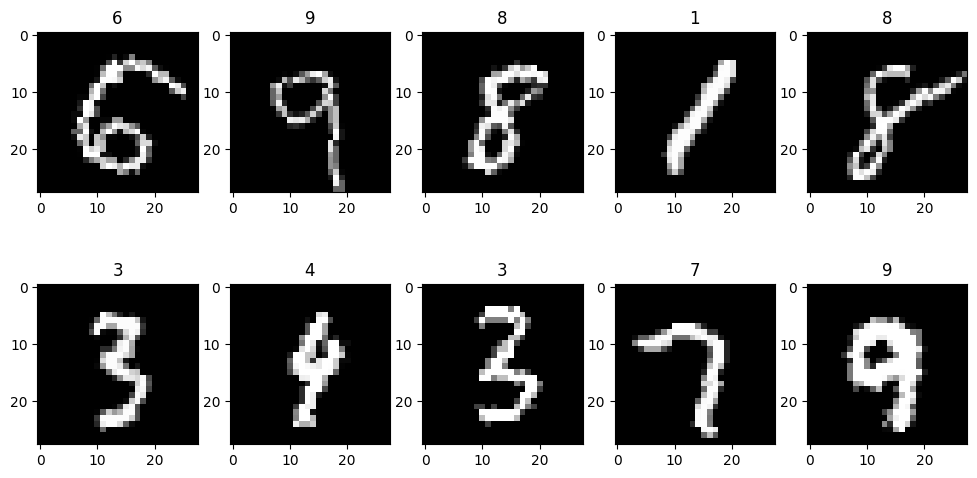

In [18]:
# Visualizing several MNIST datasets
import matplotlib.pyplot as plt

dataiter = iter(train_loader)
images, labels = next(dataiter)

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.flatten()

for i in range(10):
    axes[i].imshow(images[i].squeeze(), cmap='gray')
    axes[i].set_title(str(labels[i].item()))

### Define Model

In [19]:
class PerceptronModel(torch.nn.Module):
  def __init__(self, n_class: int, *args, **kwargs) -> None:
    super(PerceptronModel, self).__init__()
    self.n_class = n_class

    # Feature extractor (flatten input)
    self.flatten = torch.nn.Flatten()

    # Classifier (Perceptron/Simple ANN)
    self.fc1 = torch.nn.Linear(in_features=784, out_features=self.n_class)

  def forward(self, data, *args, **kwargs) -> torchvision.models:
    x = self.flatten(data)
    x = self.fc1(x)

    return x

* Set the device: **CUDA®**

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

* Call the model

In [21]:
model = PerceptronModel(n_class=784).to(device)
model

PerceptronModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=784, bias=True)
)

* Set Loss Function and Optimizer

In [22]:
loss_function = torch.nn.CrossEntropyLoss() # CrossEntropy
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE) # ADAM = Adaptive Moment Estimation

### Start model training

* Training and validation phases

In [24]:
TRAIN_LOSS, TRAIN_ACC = [], []
train_batches = len(train_loader)

VAL_LOSS, VAL_ACC = [], []
val_batches = len(valid_loader)

# loop for every epoch (training + evaluation)
start_ts = time.time()
for e in range(EPOCH): # Epoch
    train_losses = 0
    train_accuracies = 0

    # ----------------- TRAINING  --------------------
    model.train()

    for i, data in enumerate(train_loader): # Mini-Batch
      X = data[0].to(device)
      y = data[1].to(device)

      model.zero_grad()

      # forward pass
      outputs = model(X)
      loss = loss_function(outputs, y)

      # Backward pass
      loss.backward()
      optimizer.step()

      train_losses += loss.item()

      # measure Accuracy
      ps = torch.exp(outputs)
      top_p, top_class = ps.topk(1, dim=1)
      equals = top_class == y.view(*top_class.shape)
      train_accuracies += torch.mean(equals.type(torch.FloatTensor)).item()

    TRAIN_ACC.append(train_accuracies/train_batches)
    TRAIN_LOSS.append(train_losses/train_batches)

    # releasing unceseccary memory in GPU
    if torch.cuda.is_available():
      torch.cuda.empty_cache()

    # ----------------- VALIDATION  -----------------
    val_losses = 0
    val_accuracies = 0

    model.eval()
    with torch.no_grad():
      for i, data in enumerate(valid_loader):
        X = data[0].to(device)
        y = data[1].to(device)

        outputs = model(X)
        val_losses += loss_function(outputs, y).item()

        # measure Accuracy
        ps = torch.exp(outputs)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == y.view(*top_class.shape)
        val_accuracies += torch.mean(equals.type(torch.FloatTensor)).item()

    print("Epoch {}/{}".format(e+1, EPOCH))
    print("Training Loss: {:.3f}, accuracy: {:.3f}%".format(train_losses/train_batches, train_accuracies/train_batches*100))
    print("Validation Loss: {:.3f}, accuracy: {:.3f}%".format(val_losses/val_batches, val_accuracies/val_batches*100))
    print()

    VAL_ACC.append(val_accuracies/val_batches)
    VAL_LOSS.append(val_losses/val_batches)

tr_time = time.time()-start_ts
print("Training time: {:.3f}s".format(tr_time))

Epoch 1/20
Training Loss: 0.647, accuracy: 81.297%
Validation Loss: 0.471, accuracy: 85.449%

Epoch 2/20
Training Loss: 0.445, accuracy: 86.755%
Validation Loss: 0.443, accuracy: 86.934%

Epoch 3/20
Training Loss: 0.431, accuracy: 87.275%
Validation Loss: 0.433, accuracy: 86.855%

Epoch 4/20
Training Loss: 0.423, accuracy: 87.649%
Validation Loss: 0.450, accuracy: 86.514%

Epoch 5/20
Training Loss: 0.419, accuracy: 87.734%
Validation Loss: 0.425, accuracy: 87.578%

Epoch 6/20
Training Loss: 0.414, accuracy: 87.844%
Validation Loss: 0.426, accuracy: 87.021%

Epoch 7/20
Training Loss: 0.414, accuracy: 88.106%
Validation Loss: 0.416, accuracy: 87.510%

Epoch 8/20
Training Loss: 0.408, accuracy: 88.248%
Validation Loss: 0.414, accuracy: 87.559%

Epoch 9/20
Training Loss: 0.402, accuracy: 88.352%
Validation Loss: 0.423, accuracy: 87.129%

Epoch 10/20
Training Loss: 0.400, accuracy: 88.404%
Validation Loss: 0.401, accuracy: 87.754%

Epoch 11/20
Training Loss: 0.407, accuracy: 88.217%
Validat

* Evaluation

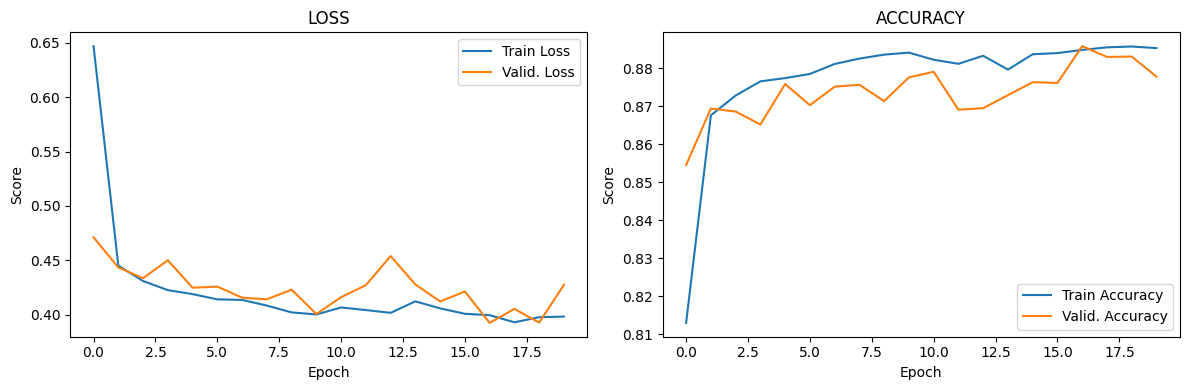

In [25]:
plot_performance({
    "train_acc": TRAIN_ACC,
    "train_loss": TRAIN_LOSS,
    "val_acc": VAL_ACC,
    "val_loss": VAL_LOSS
})

### Result

Berdasarkan hasil yang didapatkan Model jaringan saraf tiruan **Perceptron** yang telah diimplementasikan untuk mengklasifikasikan **Handwritten Digit** dalam dataset MNIST memiliki akurasi sebesar **87%**. Ini menunjukkan bahwa model cukup baik dalam mengenali digit-digit tulisan tangan. Proses pelatihan model dilakukan selama **20 epoch**, dan kinerja model terus meningkat seiring berjalannya waktu.